<a href="https://colab.research.google.com/github/umakanetkar/opioid-mortality-corelation-analysis/blob/main/Opioid_Availability_Mortality_Rate_Corelation_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction and Setup

The goal of this project is to use machine learning and statistics to see if theres a strong corelation between opioid availabilty and mortality rates in the state of Pennsylvania. There has been a marked rise in drug overdose related deaths and combined with an increase in drug availability, it makes a compelling case to find out this correlation.

To come up with data based conclusions, I am doing analysis on ungrouped, large opioid datasets recording opioid transaction data.

Article : [https://www.pennlive.com/opioid-crisis/](https://www.pennlive.com/opioid-crisis/)

Credits to Parmita Mishra who inspired me to conduct this analysis by her blog


In [1]:
%%capture
!apt install libkrb5-dev
!wget https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
! pip install pyspark --user
! pip install seaborn --user
! pip install plotly --user
! pip install imageio --user
! pip install folium --user
! pip3 install yellowbrick

In [2]:
%%capture
!apt update
!apt install gcc python-dev libkrb5-dev

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

import os

spark = SparkSession.builder.appName('Opioid-Project').getOrCreate()

In [4]:
!pip install pymongo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.0/670.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 24.0 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import matplotlib

#misc
import gc
import time
import warnings


#graph section
import networkx as nx
#import heapq  # for getting top n number of things from list,dict
import pandas as pd
import numpy as np

# JSON parsing
import json

# HTML parsing
from lxml import etree
import urllib

# SQLite RDBMS
import sqlite3

# Time conversions
import time

# NoSQL DB
from pymongo import MongoClient
from pymongo.errors import DuplicateKeyError, OperationFailure

import os
os.environ['SPARK_HOME'] = '/content/spark-2.4.5-bin-hadoop2.7'
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
import pyspark
from pyspark.sql import SQLContext

In [6]:
#spark session
try:
    if(spark == None):
        spark = SparkSession.builder.appName('Initial').getOrCreate()
        sqlContext=SQLContext(spark)
except NameError:
    spark = SparkSession.builder.appName('Initial').getOrCreate()
    sqlContext=SQLContext(spark)

# Opioid Data


I am using data sourced from the [Washington Post](https://www.washingtonpost.com/investigations/interactive/2023/opioid-epidemic-pain-pills-sold-oxycodone-hydrocodone/), in their publication of the DEA's opioid data. I have then selected the PA data from the Washington Post database.

I am chosing to go with this dataset because it was quite recently published (2019) is quite reliable, and contains the features needed for regression analysis. Additionally, data collection is consistent, and metadata is freely available and open-source.

In [7]:


!wget https://www.washingtonpost.com/wp-stat/dea-pain-pill-database/summary/arcos-pa-statewide-itemized.csv.gz
!gunzip -k arcos-pa-statewide-itemized.csv.gz

--2024-05-28 03:44:44--  https://www.washingtonpost.com/wp-stat/dea-pain-pill-database/summary/arcos-pa-statewide-itemized.csv.gz
Resolving www.washingtonpost.com (www.washingtonpost.com)... 23.10.162.92
Connecting to www.washingtonpost.com (www.washingtonpost.com)|23.10.162.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 308798971 (294M) [text/csv]
Saving to: ‘arcos-pa-statewide-itemized.csv.gz’

arcos-pa-statewide- 100%[===================>] 294.49M  52.6MB/s    in 5.2s    

2024-05-28 03:44:58 (56.9 MB/s) - ‘arcos-pa-statewide-itemized.csv.gz’ saved [308798971/308798971]



Reading the unzipped dataset to spark and taking a look at first few rows to get a general sense of data.

In [8]:
opioid_sdf = spark.read.csv('arcos-pa-statewide-itemized.csv', header=True)

opioid_sdf.show(5)

+---------------+----------------+--------------------+---------------------+--------------------+-----------------+----------------+--------------+------------+---------------+------------+---------------+--------------------+--------------------+--------------------+--------------+-----------+-----------+---------+--------------+----------------+---------+-----------+-----------+--------+----+----------------+-------------+-------------+--------+----------------+------------------+-----------+--------------+--------------------+--------------------+-------+---------------------+---------------------+--------------------+-------+--------+
|REPORTER_DEA_NO|REPORTER_BUS_ACT|       REPORTER_NAME|REPORTER_ADDL_CO_INFO|   REPORTER_ADDRESS1|REPORTER_ADDRESS2|   REPORTER_CITY|REPORTER_STATE|REPORTER_ZIP|REPORTER_COUNTY|BUYER_DEA_NO|  BUYER_BUS_ACT|          BUYER_NAME|  BUYER_ADDL_CO_INFO|      BUYER_ADDRESS1|BUYER_ADDRESS2| BUYER_CITY|BUYER_STATE|BUYER_ZIP|  BUYER_COUNTY|TRANSACTION_CODE|DR

Creating a temp view to query this table.

In [9]:
opioid_sdf.createOrReplaceTempView("opioid_tbl")

From an exploratory data analysis perspective, I am interested to look at the market shares of different quantities (in particular, quantity of units purchased, total MME, and number of transactions) for distributors from year to year.

To do so, I am aggregating data in Spark by grouping by distributor name and transaction year with the following SQL query. This gives the total quantity, MME, and number of transactions for each company from year to year, so it must be divided by the overall yearly total to get the market share; i.e.
market share (t) = distributor total (t) / overall total (t)
, where t is the year.

Once the SQL query is complete, I will convert the resulting table to a Pandas dataframe.

In [10]:
eda_query = '''SELECT BUYER_NAME AS DISTRIBUTOR,
               RIGHT(TRANSACTION_DATE, 4) AS TRANS_YEAR,
               SUM(QUANTITY) AS YEAR_QTY,
               SUM(MME) AS YEAR_MME,
               COUNT(BUYER_NAME) AS YEAR_TRANS
               FROM opioid_tbl
               GROUP BY BUYER_NAME, TRANS_YEAR'''

eda_df = spark.sql(eda_query).toPandas()

In [11]:
print(str(eda_df.head()) + "\n")
print(str(eda_df.dtypes) + "\n")
print(eda_df.shape)

                 DISTRIBUTOR TRANS_YEAR  YEAR_QTY      YEAR_MME  YEAR_TRANS
0        THE MEDICINE SHOPPE       2007   46552.0  1.074689e+08       25922
1  MONTROSE MEDICAL ARTS PHY       2007     430.0  6.566463e+05         167
2       GIANT PHARMACY #6305       2009     391.0  4.764751e+05         211
3       GIANT PHARMACY #6316       2008     424.0  8.440991e+05         266
4       GIANT PHARMACY #6291       2008     199.0  1.602124e+05         120

DISTRIBUTOR     object
TRANS_YEAR      object
YEAR_QTY       float64
YEAR_MME       float64
YEAR_TRANS       int64
dtype: object

(21643, 5)


Description of Columns:


---



DISTRIBUTOR: The pharmacy that sells the opioids directly to consumers.

TRANS_YEAR: The year during which all transactions in the data took place.

YEAR_QTY: The total number of units sold, per the given year and distributor. Units are defined as the number of pills/tablets sold.

YEAR_MME: The total sum of the MME metric, per the given year and distributor. The MME metric is defined as a universal morphine equivalence unit, which determines the strength of each transaction. This takes into account the type of unit, the number of units, the dosage, and type of opioid.

YEAR_TRANS: The total number of individual transactions made, per the given year and distributor.

# Get Market Shares

To convert the yearly quantity, MME, and transaction totals for each distributor to their respective market shares, I am dividing these columns by the overall yearly quantity, MME, and transaction totals.



In [12]:
eda_df['QTY_MKT_SHARE'] = eda_df.YEAR_QTY
eda_df['MME_MKT_SHARE'] = eda_df.YEAR_MME
eda_df['TRANS_MKT_SHARE'] = eda_df.YEAR_TRANS


def get_qty_mkt_ttl(year):
  return(np.sum(eda_df.YEAR_QTY[eda_df.TRANS_YEAR==year]))

def get_mme_mkt_ttl(year):
  return(np.sum(eda_df.YEAR_MME[eda_df.TRANS_YEAR==year]))

def get_trans_mkt_ttl(year):
  return(np.sum(eda_df.YEAR_TRANS[eda_df.TRANS_YEAR==year]))

years = pd.unique(eda_df['TRANS_YEAR'])

for year in years:
  eda_df.loc[eda_df['TRANS_YEAR']==year, 'QTY_MKT_SHARE'] = \
    eda_df.loc[eda_df['TRANS_YEAR']==year, 'QTY_MKT_SHARE'] / get_qty_mkt_ttl(year)
  eda_df.loc[eda_df['TRANS_YEAR']==year, 'MME_MKT_SHARE'] = \
    eda_df.loc[eda_df['TRANS_YEAR']==year, 'MME_MKT_SHARE'] / get_mme_mkt_ttl(year)
  eda_df.loc[eda_df['TRANS_YEAR']==year, 'TRANS_MKT_SHARE'] = \
    eda_df.loc[eda_df['TRANS_YEAR']==year, 'TRANS_MKT_SHARE'] / get_trans_mkt_ttl(year)

Printing the first 5 rows and first 50 unique distributors.

In [13]:
print(str(eda_df.head()) + "\n")
print(pd.unique(eda_df.DISTRIBUTOR)[1:50])

                 DISTRIBUTOR TRANS_YEAR  YEAR_QTY      YEAR_MME  YEAR_TRANS  \
0        THE MEDICINE SHOPPE       2007   46552.0  1.074689e+08       25922   
1  MONTROSE MEDICAL ARTS PHY       2007     430.0  6.566463e+05         167   
2       GIANT PHARMACY #6305       2009     391.0  4.764751e+05         211   
3       GIANT PHARMACY #6316       2008     424.0  8.440991e+05         266   
4       GIANT PHARMACY #6291       2008     199.0  1.602124e+05         120   

   QTY_MKT_SHARE  MME_MKT_SHARE  TRANS_MKT_SHARE  
0       0.019107       0.025716         0.025660  
1       0.000176       0.000157         0.000165  
2       0.000134       0.000093         0.000187  
3       0.000158       0.000182         0.000243  
4       0.000074       0.000035         0.000110  

['MONTROSE MEDICAL ARTS PHY' 'GIANT PHARMACY #6305' 'GIANT PHARMACY #6316'
 'GIANT PHARMACY #6291' 'GIANT PHARMACY #6087' 'GIANT PHARMACY #6112'
 'GIANT PHARMACY #6045' 'GIANT PHARMACY #6471' 'GIANT PHARMACY #6277'
 'C

I see that we have a lot of instances where we are counting the same distributor multiple number of times. For eg. "'GIANT PHARMACY #6291' 'GIANT PHARMACY #6087' 'GIANT PHARMACY #6112'
 'GIANT PHARMACY #6045'" all correspond to the same "GIANT PHARMACY"

 In further analysis, I will correct this.

# Mortality Data

Moving over to mortality data, I am sourcing it from [CDC Wonder](https://wonder.cdc.gov/cmf-icd10.html). For convenience, I uploaded this dataset to GitHub so that it could be uploaded directly to Colab from the internet.

In [14]:
# !wget https://github.com/umakanetkar/opioid-mortality-corelation-analysis/blob/main/Compressed-Mortality-1999-2016.txt
!wget https://raw.githubusercontent.com/prmrs2/gthub4455ghdrive/main/Compressed-Mortality-1999-2016.txt

--2024-05-28 03:51:17--  https://raw.githubusercontent.com/prmrs2/gthub4455ghdrive/main/Compressed-Mortality-1999-2016.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43994 (43K) [text/plain]
Saving to: ‘Compressed-Mortality-1999-2016.txt’

Compressed-Mortalit 100%[===================>]  42.96K  --.-KB/s    in 0.01s   

2024-05-28 03:51:17 (3.61 MB/s) - ‘Compressed-Mortality-1999-2016.txt’ saved [43994/43994]



Reading the data into a Pandas data frame.

In [15]:
mortality_raw = pd.read_csv('Compressed-Mortality-1999-2016.txt', header=0, sep='\t', lineterminator='\r')

mortality_raw.head(675)

,Notes,County,County Code,Year,Year Code,Deaths,Population,Crude Rate
0,\n,"Adams County, PA",42001.0,2006.0,2006.0,877.0,99899.0,877.9
1,\n,"Adams County, PA",42001.0,2007.0,2007.0,921.0,100502.0,916.4
2,\n,"Adams County, PA",42001.0,2008.0,2008.0,890.0,101056.0,880.7
3,\n,"Adams County, PA",42001.0,2009.0,2009.0,863.0,101252.0,852.3
4,\n,"Adams County, PA",42001.0,2010.0,2010.0,917.0,101407.0,904.3
...,...,...,...,...,...,...,...,...
670,"\n""Total""",NaN,NaN,NaN,NaN,1140256.0,114144318.0,999.0
671,"\n""---""",NaN,NaN,NaN,NaN,NaN,NaN,NaN
672,"\n""Dataset: Compressed Mortality, 1999-2016""",NaN,NaN,NaN,NaN,NaN,NaN,NaN
673,"\n""Query Parameters:""",NaN,NaN,NaN,NaN,NaN,NaN,NaN


Right off the bat, we see the last few columns dont have actual data. We'll take a closer look

In [16]:
mortality_raw.loc[ 665: ]

,Notes,County,County Code,Year,Year Code,Deaths,Population,Crude Rate
665,\n,"York County, PA",42133.0,2011.0,2011.0,3770.0,436845.0,863.0
666,\n,"York County, PA",42133.0,2012.0,2012.0,3680.0,437641.0,840.9
667,\n,"York County, PA",42133.0,2013.0,2013.0,3798.0,439117.0,864.9
668,\n,"York County, PA",42133.0,2014.0,2014.0,3975.0,440590.0,902.2
669,"\n""Total""","York County, PA",42133.0,NaN,NaN,32887.0,3894548.0,844.4
670,"\n""Total""",NaN,NaN,NaN,NaN,1140256.0,114144318.0,999.0
671,"\n""---""",NaN,NaN,NaN,NaN,NaN,NaN,NaN
672,"\n""Dataset: Compressed Mortality, 1999-2016""",NaN,NaN,NaN,NaN,NaN,NaN,NaN
673,"\n""Query Parameters:""",NaN,NaN,NaN,NaN,NaN,NaN,NaN
674,"\n""States: Pennsylvania (42)""",NaN,NaN,NaN,NaN,NaN,NaN,NaN


As seen above, the rows at the end are just footnotes. This occurs from row 671 onward, so I will exclude these rows from the data.

Also worth noting that, each county has an associated row in which the Notes column has the value "Total" and the Year/Year Code columns have NaN values. These rows correspond to the cumulative number of deaths over all years for the county. Since I do not need this information, I will exclude these rows. Also dropping the Notes and County columns, as the information in the Notes column is qualitative and cannot be used for modeling and the information in the County column is encoded by County Code.



In [17]:
mortality = mortality_raw[0:670]
mortality = mortality.loc[mortality.Notes != '\n"Total"']
mortality = mortality.drop(['Notes', 'County', "Year Code"], axis=1)

Column Descriptions:

County Code: The FIPS code of each county.

Year: The year for the mortality rate for the county.

Deaths: The total number of deaths in the given county and year.

Population: The total population in the given county and year.

Crude Rate: The mortality rate, given as the ratio of number of deaths per 100,000 people in the given county and year.

Because the Crude Rate variable is the mortality rate per 100,000 citizens, I will convert this to the regular death rate (
number of deaths/population size
) to get a value ranging from
[
0
,
1
]
 for later modeling.

In [18]:
mortality.loc[:, 'Crude Rate'] = mortality.loc[:, 'Crude Rate']/100000

mortality.head(603)

,County Code,Year,Deaths,Population,Crude Rate
0,42001.0,2006.0,877.0,99899.0,0.008779
1,42001.0,2007.0,921.0,100502.0,0.009164
2,42001.0,2008.0,890.0,101056.0,0.008807
3,42001.0,2009.0,863.0,101252.0,0.008523
4,42001.0,2010.0,917.0,101407.0,0.009043
...,...,...,...,...,...
664,42133.0,2010.0,3621.0,434972.0,0.008325
665,42133.0,2011.0,3770.0,436845.0,0.008630
666,42133.0,2012.0,3680.0,437641.0,0.008409
667,42133.0,2013.0,3798.0,439117.0,0.008649


# Zip Code/FIPS Data

One issue is that the mortality data is broken down at the county-level, while the opioid transactions are grouped at the zip code level. In order to aggregate the opioid data to the county-level (uniquely identified by the five digit FIPS code), I obtained a data set from GitHub which relates FIPS codes to zip codes.

In [19]:
!wget https://raw.githubusercontent.com/Data4Democracy/zip-code-to-county/master/county-fips.csv

--2024-05-28 03:52:50--  https://raw.githubusercontent.com/Data4Democracy/zip-code-to-county/master/county-fips.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91017 (89K) [text/plain]
Saving to: ‘county-fips.csv’

county-fips.csv     100%[===================>]  88.88K  --.-KB/s    in 0.02s   

2024-05-28 03:52:51 (4.04 MB/s) - ‘county-fips.csv’ saved [91017/91017]



Now that data is uploaded into Colab, I will transfer it into Pandas.

In [20]:
data_type_dict = {'STATEFP': str, 'COUNTYFP': str, 'COUNTYNAME': str}

zips_df = pd.read_csv('county-fips.csv', header=0, \
                      dtype=data_type_dict)[['STATEFP',  'COUNTYFP', \
                                             'COUNTYNAME', 'STATE']]

zips_df['FIPS'] = zips_df.apply(lambda x: float(x[0] + x[1]), axis=1)
zips_df['COUNTYNAME'] = zips_df['COUNTYNAME'].apply(lambda x: x.upper().split(' COUNTY')[0])
zips_df = zips_df[ zips_df['STATE'] == 'PA']

zips_df = zips_df.drop(['STATEFP', 'COUNTYFP', 'STATE'], axis=1)



In [21]:
zips_df.head()

,COUNTYNAME,FIPS
2244,ADAMS,42001.0
2245,ALLEGHENY,42003.0
2246,ARMSTRONG,42005.0
2247,BEAVER,42007.0
2248,BEDFORD,42009.0


# Data Cleaning

In the output of the last opioid data cell, different stores from the same company (e.g. different Giant pharmacies) are treated as separate distributors. To remedy this, I am doing some basic text manipulation with regex.

For example, the string 'GIANT PHARMACY #6054' would be converted to 'GIANT PHARMACY' and all trimmed strings are grouped together and columns are aggregated with a sum. So, any distributor that was originally of the form 'GIANT PHARMACY #XXXX' would have their totals and market shares summed together, which is valid as the columns in question are all additive.

In [22]:
eda_df.head()

,DISTRIBUTOR,TRANS_YEAR,YEAR_QTY,YEAR_MME,YEAR_TRANS,QTY_MKT_SHARE,MME_MKT_SHARE,TRANS_MKT_SHARE
0,THE MEDICINE SHOPPE,2007,46552.0,1.074689e+08,25922,0.019107,0.025716,0.025660
1,MONTROSE MEDICAL ARTS PHY,2007,430.0,6.566463e+05,167,0.000176,0.000157,0.000165
2,GIANT PHARMACY #6305,2009,391.0,4.764751e+05,211,0.000134,0.000093,0.000187
3,GIANT PHARMACY #6316,2008,424.0,8.440991e+05,266,0.000158,0.000182,0.000243
4,GIANT PHARMACY #6291,2008,199.0,1.602124e+05,120,0.000074,0.000035,0.000110


In [23]:
import re

def get_dist_sub(str):
  return(re.split('( [0-9])|( #)', str)[0])

eda_df.loc[:, 'DISTRIBUTOR'] =  eda_df.loc[:, 'DISTRIBUTOR'].apply(get_dist_sub)

eda_df_grouped = eda_df.groupby(by = ['DISTRIBUTOR', 'TRANS_YEAR']).sum().reset_index()

In [24]:
print(eda_df_grouped.head(30))
# print(pd.unique(eda_df_grouped.DISTRIBUTOR)[1175:1225])

                         DISTRIBUTOR TRANS_YEAR  YEAR_QTY      YEAR_MME  \
0             18TH STREET APOTHECARY       2008      36.0  6.682088e+04   
1             18TH STREET APOTHECARY       2009     119.0  2.136179e+05   
2             18TH STREET APOTHECARY       2010     189.0  3.796345e+05   
3             18TH STREET APOTHECARY       2011     293.0  5.951861e+05   
4             18TH STREET APOTHECARY       2012     339.0  6.481678e+05   
5             18TH STREET APOTHECARY       2013     451.0  8.650636e+05   
6             18TH STREET APOTHECARY       2014     532.0  1.483199e+06   
7           1934 DELMAR PHARMACY INC       2008    3932.0  1.362139e+07   
8           1934 DELMAR PHARMACY INC       2009    4126.0  1.394541e+07   
9           1934 DELMAR PHARMACY INC       2010    4617.0  1.491292e+07   
10          1934 DELMAR PHARMACY INC       2011    5606.0  1.734565e+07   
11          1934 DELMAR PHARMACY INC       2012    6238.0  1.784153e+07   
12          1934 DELMAR P

Also assigning, each Distributor a unique index.

In [25]:
grouped_Dist_list = pd.unique(eda_df_grouped.DISTRIBUTOR)
dict_of_grouped_Dist = {}

for i in range(0, len(grouped_Dist_list)):
  dict_of_grouped_Dist.update({grouped_Dist_list[i] : i})

In [26]:
# This unique index is then added to eda_df for our later EDA.
eda_df_grouped_Ind = eda_df_grouped.copy()
eda_df_grouped_Ind['Dist_Ind'] = 0

def get_Dist_Ind(dist):
  return(dict_of_grouped_Dist.get(dist))

eda_df_grouped_Ind['Dist_Ind'] = \
  eda_df_grouped_Ind['DISTRIBUTOR'].apply(lambda x: get_Dist_Ind(x))

eda_df_grouped_Ind.head(200)

,DISTRIBUTOR,TRANS_YEAR,YEAR_QTY,YEAR_MME,YEAR_TRANS,QTY_MKT_SHARE,MME_MKT_SHARE,TRANS_MKT_SHARE,Dist_Ind
0,18TH STREET APOTHECARY,2008,36.0,6.682088e+04,28,0.000013,0.000014,0.000026,0
1,18TH STREET APOTHECARY,2009,119.0,2.136179e+05,68,0.000041,0.000042,0.000060,0
2,18TH STREET APOTHECARY,2010,189.0,3.796345e+05,112,0.000059,0.000068,0.000093,0
3,18TH STREET APOTHECARY,2011,293.0,5.951861e+05,152,0.000080,0.000098,0.000119,0
4,18TH STREET APOTHECARY,2012,339.0,6.481678e+05,178,0.000090,0.000103,0.000135,0
...,...,...,...,...,...,...,...,...,...
195,"ADAMS & BRIGHT DRUGS, LLC",2014,599.0,1.162988e+06,316,0.000155,0.000195,0.000246,39
196,ADAMS DISCOUNT PHARMACY,2006,1625.0,4.171497e+06,647,0.000779,0.001146,0.000701,40
197,ADAMS DISCOUNT PHARMACY,2007,4543.0,9.908005e+06,1237,0.001865,0.002371,0.001225,40
198,ADAMS DISCOUNT PHARMACY,2008,6255.0,1.742785e+07,1617,0.002333,0.003753,0.001478,40


# EDA

When analyzing providers in Pennsylvania, it's important to consider the major players in the industry. However, using just one metric can be problematic. For instance, a provider might sell a large number of pills, but each pill might have a low opioid concentration. Additionally, some companies might have only recently entered the market. To address this, we need to examine annual trends in market share by quantity, transactions, and MME (morphine milligram equivalent), along with yearly mortality rates. By considering these factors, we can better understand any significant changes in market share.

### Quantity Market Share by Year

I am beginning the EDA with producing a bar plot of the various market shares of annual quantity for different distributors each year.

The most important thing to note is that each year there are only about 5-6 distributors with major proportion of the annual quantity market share. This suggests that in our later modeling, I will likely be able to focus on transactions from the top few companies without losing subtantial information.



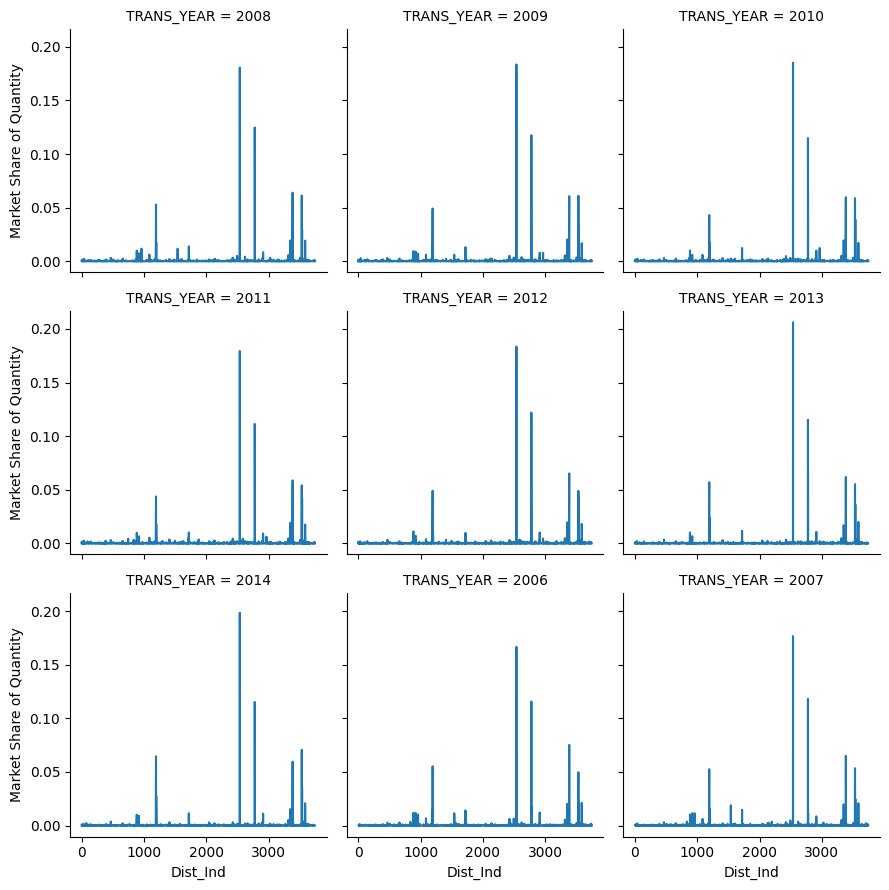

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

qty_bar_plot = sns.FacetGrid(eda_df_grouped_Ind, col="TRANS_YEAR", \
                             col_wrap=3, sharex=True)
qty_bar_plot.map(plt.plot, "Dist_Ind", "QTY_MKT_SHARE")
qty_bar_plot.set_ylabels('Market Share of Quantity')

In [28]:
years = eda_df_grouped_Ind.TRANS_YEAR.unique().tolist()

for year in years:
  print(eda_df_grouped_Ind.loc[eda_df_grouped_Ind['TRANS_YEAR']==year, \
      ['DISTRIBUTOR','TRANS_YEAR','QTY_MKT_SHARE','Dist_Ind']].\
      sort_values(by=['QTY_MKT_SHARE'], ascending=False).head(10))
  print("\n")

                             DISTRIBUTOR TRANS_YEAR  QTY_MKT_SHARE  Dist_Ind
10897  PENNSYLVANIA CVS PHARMACY, L.L.C.       2008       0.180569      2538
11960     RITE AID OF PENNSYLVANIA, INC.       2008       0.124746      2778
14659                  THRIFT DRUG, INC.       2008       0.063948      3386
15362                  WAL-MART PHARMACY       2008       0.061270      3533
5112                GIANT EAGLE PHARMACY       2008       0.052913      1193
15395         WALGREEN EASTERN CO., INC.       2008       0.029911      3538
14517                THE MEDICINE SHOPPE       2008       0.019411      3351
15663                      WEIS PHARMACY       2008       0.019215      3587
5134                      GIANT PHARMACY       2008       0.017629      1196
7317                      KMART PHARMACY       2008       0.013868      1720


                             DISTRIBUTOR TRANS_YEAR  QTY_MKT_SHARE  Dist_Ind
10898  PENNSYLVANIA CVS PHARMACY, L.L.C.       2009       0.183555      25

### MME Market Share by Year

Likewise, we produce a similar bar plot of the market shares of annual MME for different distributors each year.

We again observe that each year's chart is dominated by about 6-7 spikes, further providing credence to only using the top 5 or so distributors when it comes to ML model.

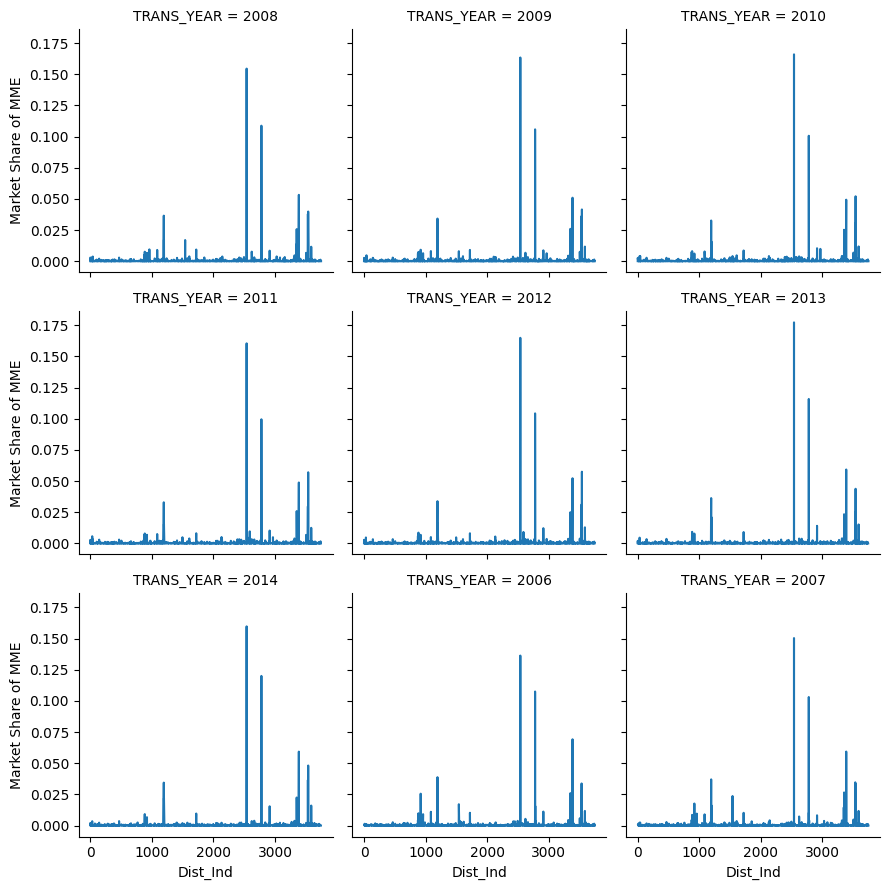

In [29]:
qty_bar_plot = sns.FacetGrid(eda_df_grouped_Ind, col="TRANS_YEAR", \
                             col_wrap=3, sharex=True)
qty_bar_plot.map(plt.plot, "Dist_Ind", "MME_MKT_SHARE")
qty_bar_plot.set_ylabels('Market Share of MME')


In [30]:
## Get Top 10 Distributors for each year and their totals:

years = pd.unique(eda_df_grouped_Ind['TRANS_YEAR'])

for year in years:
  print(eda_df_grouped_Ind.loc[eda_df_grouped_Ind['TRANS_YEAR']==year, ['DISTRIBUTOR','TRANS_YEAR','MME_MKT_SHARE','Dist_Ind']].\
             sort_values(by=['MME_MKT_SHARE'], ascending=False).head(10))
  print("\n")


                             DISTRIBUTOR TRANS_YEAR  MME_MKT_SHARE  Dist_Ind
10897  PENNSYLVANIA CVS PHARMACY, L.L.C.       2008       0.154563      2538
11960     RITE AID OF PENNSYLVANIA, INC.       2008       0.108770      2778
14659                  THRIFT DRUG, INC.       2008       0.053263      3386
15395         WALGREEN EASTERN CO., INC.       2008       0.039876      3538
15362                  WAL-MART PHARMACY       2008       0.037934      3533
5112                GIANT EAGLE PHARMACY       2008       0.036571      1193
14517                THE MEDICINE SHOPPE       2008       0.025741      3351
5134                      GIANT PHARMACY       2008       0.017259      1196
6533                  INNOVIANT PHARMACY       2008       0.017011      1540
14478              THE HOMETOWN PHARMACY       2008       0.013504      3346


                             DISTRIBUTOR TRANS_YEAR  MME_MKT_SHARE  Dist_Ind
10898  PENNSYLVANIA CVS PHARMACY, L.L.C.       2009       0.163482      25

### Transactions Market Share by Year

Also producing an analogous plot for yearly transaction market share.

I see the similar observation holds: each year's plot has several spikes that make up the marjority of the annual transaction total.



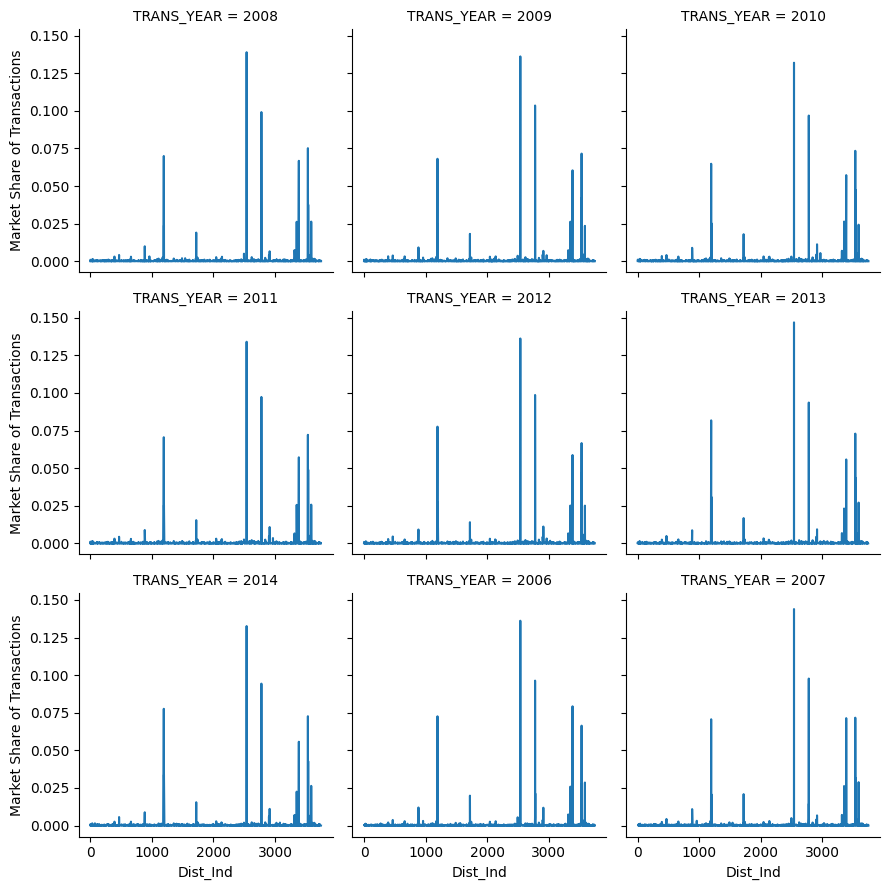

In [31]:
qty_bar_plot = sns.FacetGrid(eda_df_grouped_Ind, col="TRANS_YEAR", \
                             col_wrap=3, sharex=True)
qty_bar_plot.map(plt.plot, "Dist_Ind", "TRANS_MKT_SHARE")
qty_bar_plot.set_ylabels('Market Share of Transactions')

In [32]:
## Get Top 10 Distributors for each year and their totals:

years = pd.unique(eda_df_grouped_Ind['TRANS_YEAR'])

for year in years:
  print(eda_df_grouped_Ind.loc[eda_df_grouped_Ind['TRANS_YEAR']==year, \
      ['DISTRIBUTOR','TRANS_YEAR','TRANS_MKT_SHARE','Dist_Ind']].\
      sort_values(by=['TRANS_MKT_SHARE'], ascending=False).head(10))
  print("\n")

                             DISTRIBUTOR TRANS_YEAR  TRANS_MKT_SHARE  Dist_Ind
10897  PENNSYLVANIA CVS PHARMACY, L.L.C.       2008         0.138961      2538
11960     RITE AID OF PENNSYLVANIA, INC.       2008         0.099153      2778
15362                  WAL-MART PHARMACY       2008         0.075162      3533
5112                GIANT EAGLE PHARMACY       2008         0.069968      1193
14659                  THRIFT DRUG, INC.       2008         0.066771      3386
15395         WALGREEN EASTERN CO., INC.       2008         0.037599      3538
15663                      WEIS PHARMACY       2008         0.026344      3587
14517                THE MEDICINE SHOPPE       2008         0.026226      3351
5134                      GIANT PHARMACY       2008         0.023813      1196
7317                      KMART PHARMACY       2008         0.019031      1720


                             DISTRIBUTOR TRANS_YEAR  TRANS_MKT_SHARE  Dist_Ind
10898  PENNSYLVANIA CVS PHARMACY, L.L.C.       200

### Mortality Rate by Year

Finally, producing histogram visualizations to show the distribution of mortality rate per year across counties. We see that these visualizations show roughly normal distributions across years.

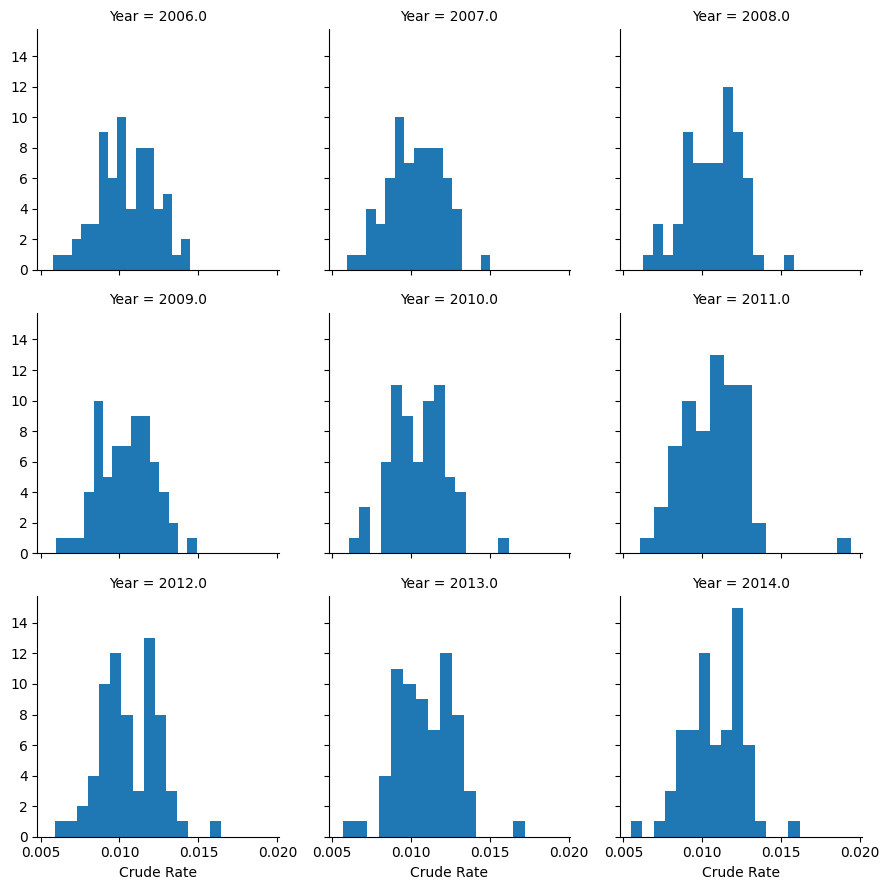

In [33]:
qty_bar_plot = sns.FacetGrid(mortality, col="Year", col_wrap=3, sharex=True)
qty_bar_plot.map(plt.hist, "Crude Rate", bins=15)

# Modelling

Re-querying the opioid data table, this time grouping by zipcode, distributor, and transaction year. Adding the grouping by zipcode so that we can build our model on units uniquely defined by (county, year) like the mortality data.

In [34]:
opioid_query = '''SELECT
                     BUYER_NAME AS DISTRIBUTOR,
                     BUYER_COUNTY AS COUNTY_NAME,
                     INT(RIGHT(TRANSACTION_DATE, 4)) AS TRANS_YEAR,
                     SUM(QUANTITY) AS YEAR_QTY,
                     SUM(MME) AS YEAR_MME,
                     COUNT(BUYER_NAME) AS YEAR_TRANS
                 FROM opioid_tbl
                 GROUP BY DISTRIBUTOR, COUNTY_NAME, TRANS_YEAR'''

raw_opioid_df = spark.sql(opioid_query).toPandas().dropna()

In [35]:
raw_opioid_df[['DISTRIBUTOR', 'COUNTY_NAME']]

,DISTRIBUTOR,COUNTY_NAME
0,"PENNSYLVANIA CVS PHARMACY, L.L.C.",LUZERNE
1,"PENNSYLVANIA CVS PHARMACY, L.L.C.",LACKAWANNA
2,MAT'S PHARMACY,BUCKS
3,GIANT PHARMACY #6081,LUZERNE
4,KMART PHARMACY #3268,LUZERNE
...,...,...
24837,"TEANO, DAN A MD",DELAWARE
24838,"HAGEN, TANYA J MD",ALLEGHENY
24839,"EMAS, ROBERT M VMD",DELAWARE
24840,"BACH, GREGORY PAUL DO",MONTGOMERY


In [36]:
#Getting distinct indexes for distributors, as done previously

raw_opioid_df.loc[:, 'DISTRIBUTOR'] =  raw_opioid_df.loc[:, 'DISTRIBUTOR'].apply(get_dist_sub)

opioid_df = raw_opioid_df.groupby(by = ['DISTRIBUTOR', 'TRANS_YEAR', 'COUNTY_NAME']).sum().reset_index()

In [37]:
print(str(opioid_df.head()) + "\n")
print(str(opioid_df.dtypes) + "\n")
print(str(opioid_df.shape) + "\n")
print(pd.unique(opioid_df.COUNTY_NAME))

              DISTRIBUTOR  TRANS_YEAR   COUNTY_NAME  YEAR_QTY     YEAR_MME  \
0  18TH STREET APOTHECARY      2008.0  PHILADELPHIA      36.0   66820.8750   
1  18TH STREET APOTHECARY      2009.0  PHILADELPHIA     119.0  213617.9025   
2  18TH STREET APOTHECARY      2010.0  PHILADELPHIA     189.0  379634.4750   
3  18TH STREET APOTHECARY      2011.0  PHILADELPHIA     293.0  595186.0800   
4  18TH STREET APOTHECARY      2012.0  PHILADELPHIA     339.0  648167.8500   

   YEAR_TRANS  
0          28  
1          68  
2         112  
3         152  
4         178  

DISTRIBUTOR     object
TRANS_YEAR     float64
COUNTY_NAME     object
YEAR_QTY       float64
YEAR_MME       float64
YEAR_TRANS       int64
dtype: object

(21519, 6)

['PHILADELPHIA' 'DELAWARE' 'BUCKS' 'BEAVER' 'FRANKLIN' 'MONTGOMERY'
 'ALLEGHENY' 'CENTRE' 'BERKS' 'WESTMORELAND' 'COLUMBIA' 'CHESTER' 'ADAMS'
 'CLEARFIELD' 'LUZERNE' 'YORK' 'INDIANA' 'FAYETTE' 'ERIE' 'UNION' 'CARBON'
 'CUMBERLAND' 'BLAIR' 'PIKE' 'LACKAWANNA' 'LEHIGH' '

###  Calculating Market Shares
Re-calculating the market shares for each distributor for a given year and county.

In [38]:
opioid_df['QTY_MKT_SHARE'] = opioid_df.YEAR_QTY
opioid_df['MME_MKT_SHARE'] = opioid_df.YEAR_MME
opioid_df['TRANS_MKT_SHARE'] = opioid_df.YEAR_TRANS


def get_qty_mkt_ttl(year, county):
  return(np.sum(opioid_df.loc[(opioid_df.TRANS_YEAR==year) & \
                              (opioid_df.COUNTY_NAME==county), 'YEAR_QTY']))

def get_mme_mkt_ttl(year, county):
  return(np.sum(opioid_df.loc[(opioid_df.TRANS_YEAR==year) & \
                              (opioid_df.COUNTY_NAME==county), 'YEAR_MME']))

def get_trans_mkt_ttl(year, county):
  return(np.sum(opioid_df.loc[(opioid_df.TRANS_YEAR==year) & \
                              (opioid_df.COUNTY_NAME==county), 'YEAR_TRANS']))

years = pd.unique(opioid_df['TRANS_YEAR'])
counties = pd.unique(opioid_df['COUNTY_NAME'])


for year in years:
  for county in counties:
    opioid_df.loc[(opioid_df['TRANS_YEAR']==year) & \
                  (opioid_df['COUNTY_NAME']==county), \
                  'QTY_MKT_SHARE'] = \
      opioid_df.loc[(opioid_df['TRANS_YEAR']==year) & \
                    (opioid_df['COUNTY_NAME']==county), \
                    'QTY_MKT_SHARE'] / get_qty_mkt_ttl(year, county)

    opioid_df.loc[(opioid_df['TRANS_YEAR']==year) & \
                  (opioid_df['COUNTY_NAME']==county), \
                  'MME_MKT_SHARE'] = \
      opioid_df.loc[(opioid_df['TRANS_YEAR']==year) & \
                    (opioid_df['COUNTY_NAME']==county), \
                    'MME_MKT_SHARE'] / get_mme_mkt_ttl(year, county)

    opioid_df.loc[(opioid_df['TRANS_YEAR']==year) & \
                  (opioid_df['COUNTY_NAME']==county), \
                  'TRANS_MKT_SHARE'] = \
      opioid_df.loc[(opioid_df['TRANS_YEAR']==year) & \
                    (opioid_df['COUNTY_NAME']==county), \
                    'TRANS_MKT_SHARE'] / get_trans_mkt_ttl(year, county)

In [39]:
opioid_df.head(10)

,DISTRIBUTOR,TRANS_YEAR,COUNTY_NAME,YEAR_QTY,YEAR_MME,YEAR_TRANS,QTY_MKT_SHARE,MME_MKT_SHARE,TRANS_MKT_SHARE
0,18TH STREET APOTHECARY,2008.0,PHILADELPHIA,36.0,6.682088e+04,28,0.000108,0.000102,0.000266
1,18TH STREET APOTHECARY,2009.0,PHILADELPHIA,119.0,2.136179e+05,68,0.000331,0.000276,0.000599
2,18TH STREET APOTHECARY,2010.0,PHILADELPHIA,189.0,3.796345e+05,112,0.000466,0.000436,0.000922
3,18TH STREET APOTHECARY,2011.0,PHILADELPHIA,293.0,5.951861e+05,152,0.000599,0.000561,0.001153
4,18TH STREET APOTHECARY,2012.0,PHILADELPHIA,339.0,6.481678e+05,178,0.000668,0.000607,0.001284
5,18TH STREET APOTHECARY,2013.0,PHILADELPHIA,451.0,8.650636e+05,258,0.000958,0.000918,0.001750
6,18TH STREET APOTHECARY,2014.0,PHILADELPHIA,532.0,1.483199e+06,261,0.001123,0.001539,0.001756
7,1934 DELMAR PHARMACY INC,2008.0,DELAWARE,3932.0,1.362139e+07,1088,0.026706,0.051632,0.023581
8,1934 DELMAR PHARMACY INC,2009.0,DELAWARE,4126.0,1.394541e+07,1143,0.024904,0.044953,0.024296
9,1934 DELMAR PHARMACY INC,2010.0,DELAWARE,4617.0,1.491292e+07,1248,0.025497,0.044256,0.025112


### Join Opioid and FIPS Data

Combining the opioid data with the FIPS dataset to aggregate to the county-level, in order to match up with our mortality data.

In [40]:
merged_opioid_df = opioid_df.merge(zips_df, \
                                   left_on='COUNTY_NAME', \
                                   right_on='COUNTYNAME').\
                                   drop_duplicates().\
                                   drop(['COUNTY_NAME', 'COUNTYNAME'], axis=1)

print(str(merged_opioid_df.head(123892)) + "\n")
print(str(merged_opioid_df.shape) + "\n")


merged_opioid_df

                  DISTRIBUTOR  TRANS_YEAR  YEAR_QTY     YEAR_MME  YEAR_TRANS  \
0      18TH STREET APOTHECARY      2008.0      36.0   66820.8750          28   
1      18TH STREET APOTHECARY      2009.0     119.0  213617.9025          68   
2      18TH STREET APOTHECARY      2010.0     189.0  379634.4750         112   
3      18TH STREET APOTHECARY      2011.0     293.0  595186.0800         152   
4      18TH STREET APOTHECARY      2012.0     339.0  648167.8500         178   
...                       ...         ...       ...          ...         ...   
21514       TIONESTA PHARMACY      2010.0     519.0  721390.9875         391   
21515       TIONESTA PHARMACY      2011.0     528.0  758859.4875         377   
21516       TIONESTA PHARMACY      2012.0     472.0  566644.5900         318   
21517       TIONESTA PHARMACY      2013.0     372.0  515760.1500         246   
21518       TIONESTA PHARMACY      2014.0     289.0  523357.2000         229   

       QTY_MKT_SHARE  MME_MKT_SHARE  TR

,DISTRIBUTOR,TRANS_YEAR,YEAR_QTY,YEAR_MME,YEAR_TRANS,QTY_MKT_SHARE,MME_MKT_SHARE,TRANS_MKT_SHARE,FIPS
0,18TH STREET APOTHECARY,2008.0,36.0,66820.8750,28,0.000108,0.000102,0.000266,42101.0
1,18TH STREET APOTHECARY,2009.0,119.0,213617.9025,68,0.000331,0.000276,0.000599,42101.0
2,18TH STREET APOTHECARY,2010.0,189.0,379634.4750,112,0.000466,0.000436,0.000922,42101.0
3,18TH STREET APOTHECARY,2011.0,293.0,595186.0800,152,0.000599,0.000561,0.001153,42101.0
4,18TH STREET APOTHECARY,2012.0,339.0,648167.8500,178,0.000668,0.000607,0.001284,42101.0
...,...,...,...,...,...,...,...,...,...
21514,TIONESTA PHARMACY,2010.0,519.0,721390.9875,391,0.581187,0.536512,0.562590,42053.0
21515,TIONESTA PHARMACY,2011.0,528.0,758859.4875,377,0.606897,0.557934,0.579109,42053.0
21516,TIONESTA PHARMACY,2012.0,472.0,566644.5900,318,0.592221,0.516745,0.545455,42053.0
21517,TIONESTA PHARMACY,2013.0,372.0,515760.1500,246,0.433062,0.451459,0.387402,42053.0


### Aggregate to County-Level

Aggregating data to the county-level, using FIPS in the groupby.

In [41]:
final_opioid_df = merged_opioid_df.groupby(by = ['DISTRIBUTOR', 'TRANS_YEAR', 'FIPS']).sum().reset_index()

final_opioid_df

,DISTRIBUTOR,TRANS_YEAR,FIPS,YEAR_QTY,YEAR_MME,YEAR_TRANS,QTY_MKT_SHARE,MME_MKT_SHARE,TRANS_MKT_SHARE
0,18TH STREET APOTHECARY,2008.0,42101.0,36.0,66820.8750,28,0.000108,0.000102,0.000266
1,18TH STREET APOTHECARY,2009.0,42101.0,119.0,213617.9025,68,0.000331,0.000276,0.000599
2,18TH STREET APOTHECARY,2010.0,42101.0,189.0,379634.4750,112,0.000466,0.000436,0.000922
3,18TH STREET APOTHECARY,2011.0,42101.0,293.0,595186.0800,152,0.000599,0.000561,0.001153
4,18TH STREET APOTHECARY,2012.0,42101.0,339.0,648167.8500,178,0.000668,0.000607,0.001284
...,...,...,...,...,...,...,...,...,...
21514,"ZWEIMAN, BURTON, MD",2006.0,42101.0,3.0,1816.2000,2,0.000012,0.000004,0.000023
21515,"ZWEIMAN, BURTON, MD",2007.0,42101.0,5.0,5448.6000,3,0.000017,0.000010,0.000032
21516,"ZWEIMAN, BURTON, MD",2008.0,42101.0,1.0,3027.0000,1,0.000003,0.000005,0.000009
21517,"ZWEIMAN, BURTON, MD",2009.0,42101.0,2.0,6054.0000,2,0.000006,0.000008,0.000018


In [42]:
final_opioid_df.head()

,DISTRIBUTOR,TRANS_YEAR,FIPS,YEAR_QTY,YEAR_MME,YEAR_TRANS,QTY_MKT_SHARE,MME_MKT_SHARE,TRANS_MKT_SHARE
0,18TH STREET APOTHECARY,2008.0,42101.0,36.0,66820.8750,28,0.000108,0.000102,0.000266
1,18TH STREET APOTHECARY,2009.0,42101.0,119.0,213617.9025,68,0.000331,0.000276,0.000599
2,18TH STREET APOTHECARY,2010.0,42101.0,189.0,379634.4750,112,0.000466,0.000436,0.000922
3,18TH STREET APOTHECARY,2011.0,42101.0,293.0,595186.0800,152,0.000599,0.000561,0.001153
4,18TH STREET APOTHECARY,2012.0,42101.0,339.0,648167.8500,178,0.000668,0.000607,0.001284


### Reformatting Opioid Data

Now that opioid data is prepped, I will reformate it so that it can be merged with the mortality data. This is because the mortality data rows are uniquely identified by (county, year), while the opioid data rows are uniquely identified by (county, year, distributor).

I am selecting the top 5 distributors for each type of market share for every (county, year) pair. These are used as columns in a new data frame that's uniquely identified by (county, year) pairs. For any (county, year) pair that doesn't have 5 distributors,I will simply append NaN values.

In [43]:
new_opioid_df = final_opioid_df.copy(deep=True)

fips = pd.unique(new_opioid_df['FIPS'])
years = pd.unique(new_opioid_df['TRANS_YEAR'])

frames = []

for fip in fips:
  for year in years:
    df_QTY = new_opioid_df.loc[(new_opioid_df['FIPS']==fip) & \
                               (new_opioid_df['TRANS_YEAR']==year), \
        ['TRANS_YEAR', 'FIPS', 'QTY_MKT_SHARE', 'MME_MKT_SHARE', 'TRANS_MKT_SHARE']].\
        sort_values(by=['QTY_MKT_SHARE'], ascending=False).head(5)
    df_MME = new_opioid_df.loc[(new_opioid_df['FIPS']==fip) & \
                               (new_opioid_df['TRANS_YEAR']==year), \
        ['TRANS_YEAR', 'FIPS', 'QTY_MKT_SHARE', 'MME_MKT_SHARE', 'TRANS_MKT_SHARE']].\
        sort_values(by=['MME_MKT_SHARE'], ascending=False).head(5)
    df_TRANS = new_opioid_df.loc[(new_opioid_df['FIPS']==fip) & \
                                 (new_opioid_df['TRANS_YEAR']==year), \
        ['TRANS_YEAR', 'FIPS', 'QTY_MKT_SHARE', 'MME_MKT_SHARE', 'TRANS_MKT_SHARE']].\
        sort_values(by=['TRANS_MKT_SHARE'], ascending=False).head(5)

    vals = list()
    vals.append(year)
    vals.append(fip)

    # If there are at least 5 distributors for this (FIPS, year) pair, take all
    # of them
    if(len(df_QTY) >= 5):
      vals.append(df_QTY.iloc[0]['QTY_MKT_SHARE'])
      vals.append(df_MME.iloc[0]['MME_MKT_SHARE'])
      vals.append(df_TRANS.iloc[0]['TRANS_MKT_SHARE'])

      vals.append(df_QTY.iloc[1]['QTY_MKT_SHARE'])
      vals.append(df_MME.iloc[1]['MME_MKT_SHARE'])
      vals.append(df_TRANS.iloc[1]['TRANS_MKT_SHARE'])

      vals.append(df_QTY.iloc[2]['QTY_MKT_SHARE'])
      vals.append(df_MME.iloc[2]['MME_MKT_SHARE'])
      vals.append(df_TRANS.iloc[2]['TRANS_MKT_SHARE'])

      vals.append(df_QTY.iloc[3]['QTY_MKT_SHARE'])
      vals.append(df_MME.iloc[3]['MME_MKT_SHARE'])
      vals.append(df_TRANS.iloc[3]['TRANS_MKT_SHARE'])

      vals.append(df_QTY.iloc[4]['QTY_MKT_SHARE'])
      vals.append(df_MME.iloc[4]['MME_MKT_SHARE'])
      vals.append(df_TRANS.iloc[4]['TRANS_MKT_SHARE'])

    # Otherwise, take as many as there are and append NaN for the rest
    else:
      ind = 0

      for i in range(len(df_QTY)):
        vals.append(df_QTY.iloc[i]['QTY_MKT_SHARE'])
        vals.append(df_QTY.iloc[i]['MME_MKT_SHARE'])
        vals.append(df_QTY.iloc[i]['TRANS_MKT_SHARE'])
        ind = ind+1
      while(ind < 5):
        vals.append(np.nan)
        vals.append(np.nan)
        vals.append(np.nan)
        ind = ind+1

    df_per_year = pd.DataFrame([vals],
        columns= ['TRANS_YEAR', 'FIPS', 'QTY_MKT_SHARE_1', 'MME_MKT_SHARE_1', 'TRANS_MKT_SHARE_1', \
                  'QTY_MKT_SHARE_2', 'MME_MKT_SHARE_2', 'TRANS_MKT_SHARE_2', \
                  'QTY_MKT_SHARE_3', 'MME_MKT_SHARE_3', 'TRANS_MKT_SHARE_3', \
                  'QTY_MKT_SHARE_4', 'MME_MKT_SHARE_4', 'TRANS_MKT_SHARE_4', \
                  'QTY_MKT_SHARE_5', 'MME_MKT_SHARE_5', 'TRANS_MKT_SHARE_5', \
                  ])
    frames.append(df_per_year)

result_df = pd.concat(frames).reset_index(drop=True)

result_df #67 unique fips, 9 unique years = 603 rows


,TRANS_YEAR,FIPS,QTY_MKT_SHARE_1,MME_MKT_SHARE_1,TRANS_MKT_SHARE_1,QTY_MKT_SHARE_2,MME_MKT_SHARE_2,TRANS_MKT_SHARE_2,QTY_MKT_SHARE_3,MME_MKT_SHARE_3,TRANS_MKT_SHARE_3,QTY_MKT_SHARE_4,MME_MKT_SHARE_4,TRANS_MKT_SHARE_4,QTY_MKT_SHARE_5,MME_MKT_SHARE_5,TRANS_MKT_SHARE_5
0,2008.0,42101.0,0.173565,0.123444,0.143525,0.156022,0.109962,0.141656,0.037559,0.047631,0.063822,0.032095,0.045428,0.032029,0.026694,0.029700,0.022893
1,2009.0,42101.0,0.165141,0.121120,0.140689,0.135644,0.103432,0.131379,0.036236,0.050175,0.059410,0.029544,0.039936,0.029251,0.025547,0.024333,0.017510
2,2010.0,42101.0,0.148441,0.105875,0.128640,0.122616,0.088200,0.115595,0.038632,0.046475,0.064320,0.025726,0.044371,0.028001,0.024813,0.023596,0.022870
3,2011.0,42101.0,0.125142,0.084038,0.123214,0.104024,0.071927,0.110710,0.039739,0.055439,0.064069,0.032705,0.046531,0.028127,0.024013,0.039195,0.021146
4,2012.0,42101.0,0.117071,0.083616,0.124287,0.116019,0.083191,0.095659,0.053284,0.067129,0.064693,0.026224,0.053754,0.028008,0.025580,0.028340,0.023413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,2012.0,42053.0,0.592221,0.516745,0.545455,0.407779,0.483255,0.454545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
599,2013.0,42053.0,0.566938,0.548541,0.612598,0.433062,0.451459,0.387402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
600,2014.0,42053.0,0.536859,0.542965,0.539235,0.463141,0.457035,0.460765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
601,2006.0,42053.0,0.474108,0.446006,0.479885,0.254315,0.403580,0.272989,0.154200,0.141379,0.165230,0.117376,0.009036,0.081897,NaN,NaN,NaN


### Merge Opioid and Mortality Data

Because the opioid data is finally in correct format, I am merging it with the mortality data to get the final data frame for the modeling.

In [44]:
model_df = mortality.merge(result_df, \
                           left_on=['County Code', 'Year'], \
                           right_on = ['FIPS', 'TRANS_YEAR']).\
                           drop(['County Code', 'Deaths', \
                                 'Population', 'TRANS_YEAR'], axis=1)

model_df = model_df.loc[:, ['FIPS', 'Year', 'Crude Rate', \
                           'QTY_MKT_SHARE_1', 'QTY_MKT_SHARE_2', \
                           'QTY_MKT_SHARE_3', 'QTY_MKT_SHARE_4', \
                           'QTY_MKT_SHARE_5', \
                           'MME_MKT_SHARE_1', 'MME_MKT_SHARE_2', \
                           'MME_MKT_SHARE_3', 'MME_MKT_SHARE_4', \
                           'MME_MKT_SHARE_5', \
                           'TRANS_MKT_SHARE_1', 'TRANS_MKT_SHARE_2', \
                           'TRANS_MKT_SHARE_3', 'TRANS_MKT_SHARE_4', \
                           'TRANS_MKT_SHARE_5']]

model_df

,FIPS,Year,Crude Rate,QTY_MKT_SHARE_1,QTY_MKT_SHARE_2,QTY_MKT_SHARE_3,QTY_MKT_SHARE_4,QTY_MKT_SHARE_5,MME_MKT_SHARE_1,MME_MKT_SHARE_2,MME_MKT_SHARE_3,MME_MKT_SHARE_4,MME_MKT_SHARE_5,TRANS_MKT_SHARE_1,TRANS_MKT_SHARE_2,TRANS_MKT_SHARE_3,TRANS_MKT_SHARE_4,TRANS_MKT_SHARE_5
0,42001.0,2006.0,0.008779,0.222673,0.127417,0.104499,0.081769,0.075922,0.190771,0.134789,0.109476,0.089791,0.087018,0.136615,0.113016,0.102323,0.095317,0.094948
1,42001.0,2007.0,0.009164,0.224286,0.138214,0.090179,0.084018,0.082589,0.165286,0.129377,0.121639,0.096337,0.094945,0.119760,0.115043,0.110688,0.108147,0.101978
2,42001.0,2008.0,0.008807,0.228524,0.142285,0.089491,0.081068,0.074479,0.154687,0.137998,0.108837,0.108751,0.093920,0.125220,0.122578,0.101796,0.099507,0.095456
3,42001.0,2009.0,0.008523,0.179972,0.148127,0.099408,0.095610,0.078811,0.163261,0.128561,0.116757,0.115093,0.100471,0.130893,0.104839,0.102978,0.101117,0.095689
4,42001.0,2010.0,0.009043,0.175919,0.139038,0.109814,0.086141,0.078101,0.140974,0.130566,0.125012,0.115580,0.098974,0.112840,0.106532,0.103308,0.097281,0.094477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,42133.0,2010.0,0.008325,0.178708,0.124504,0.118257,0.109467,0.095950,0.170006,0.137492,0.129902,0.110031,0.078015,0.129927,0.116284,0.113401,0.107528,0.100355
599,42133.0,2011.0,0.008630,0.160011,0.149521,0.105344,0.101516,0.092590,0.182845,0.138962,0.128451,0.113269,0.077465,0.129919,0.120220,0.117894,0.112651,0.100200
600,42133.0,2012.0,0.008409,0.199291,0.134369,0.124408,0.100390,0.092087,0.201035,0.128347,0.121824,0.117539,0.081685,0.129811,0.127307,0.122089,0.103605,0.102889
601,42133.0,2013.0,0.008649,0.204472,0.121244,0.117848,0.096070,0.094849,0.203895,0.140365,0.135788,0.099883,0.079784,0.138224,0.131530,0.120158,0.099740,0.096995


In [45]:
#Dropping NaNs
model_df_drop = model_df.dropna()
model_df_drop

,FIPS,Year,Crude Rate,QTY_MKT_SHARE_1,QTY_MKT_SHARE_2,QTY_MKT_SHARE_3,QTY_MKT_SHARE_4,QTY_MKT_SHARE_5,MME_MKT_SHARE_1,MME_MKT_SHARE_2,MME_MKT_SHARE_3,MME_MKT_SHARE_4,MME_MKT_SHARE_5,TRANS_MKT_SHARE_1,TRANS_MKT_SHARE_2,TRANS_MKT_SHARE_3,TRANS_MKT_SHARE_4,TRANS_MKT_SHARE_5
0,42001.0,2006.0,0.008779,0.222673,0.127417,0.104499,0.081769,0.075922,0.190771,0.134789,0.109476,0.089791,0.087018,0.136615,0.113016,0.102323,0.095317,0.094948
1,42001.0,2007.0,0.009164,0.224286,0.138214,0.090179,0.084018,0.082589,0.165286,0.129377,0.121639,0.096337,0.094945,0.119760,0.115043,0.110688,0.108147,0.101978
2,42001.0,2008.0,0.008807,0.228524,0.142285,0.089491,0.081068,0.074479,0.154687,0.137998,0.108837,0.108751,0.093920,0.125220,0.122578,0.101796,0.099507,0.095456
3,42001.0,2009.0,0.008523,0.179972,0.148127,0.099408,0.095610,0.078811,0.163261,0.128561,0.116757,0.115093,0.100471,0.130893,0.104839,0.102978,0.101117,0.095689
4,42001.0,2010.0,0.009043,0.175919,0.139038,0.109814,0.086141,0.078101,0.140974,0.130566,0.125012,0.115580,0.098974,0.112840,0.106532,0.103308,0.097281,0.094477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,42133.0,2010.0,0.008325,0.178708,0.124504,0.118257,0.109467,0.095950,0.170006,0.137492,0.129902,0.110031,0.078015,0.129927,0.116284,0.113401,0.107528,0.100355
599,42133.0,2011.0,0.008630,0.160011,0.149521,0.105344,0.101516,0.092590,0.182845,0.138962,0.128451,0.113269,0.077465,0.129919,0.120220,0.117894,0.112651,0.100200
600,42133.0,2012.0,0.008409,0.199291,0.134369,0.124408,0.100390,0.092087,0.201035,0.128347,0.121824,0.117539,0.081685,0.129811,0.127307,0.122089,0.103605,0.102889
601,42133.0,2013.0,0.008649,0.204472,0.121244,0.117848,0.096070,0.094849,0.203895,0.140365,0.135788,0.099883,0.079784,0.138224,0.131530,0.120158,0.099740,0.096995


Splitting the independent and dependent variables into separate objects.

In [46]:
label = model_df_drop['Crude Rate']
features = model_df_drop.loc[:, model_df_drop.columns != 'Crude Rate']

### Test Train Split

Now splitting the data using a 30/70 testing/training split for validation. Fixing the random seed for the split so that the analysis is consistent across notebook runs.

### Linear Regression

In [47]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = \
  train_test_split(features, label, test_size=0.3, random_state=11)

In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lm = LinearRegression()
lm_model = lm.fit(x_train, y_train)
lm_y_pred = lm.predict(x_test)

In [49]:
print('MSE: ' + str(mean_squared_error(y_test, lm_y_pred)))

MSE: 2.5991011138732443e-06


In [50]:
lm_score = lm.score(x_test, y_test)
print('R^2: ' + str(lm_score))

R^2: 0.18829847424316548


Although an
R
2
 value of ~0.19 may not seem particularly high, it is important to note that this means that just by looking at the market shares top 5 distributors for each (county, year) pair, we account for almost 20% of the variability in the annual mortality rate for each county. The strength of the association between these market shares and the mortality rate corroborates the notion that a leading cause of death in PA prior to the COVID-19 pandemic were deaths related opioid-usage.

Now that we have looked at the overall model performance, we dig down to look at the specific model coefficient values.

In [51]:
print(lm.coef_)

[ 3.80858941e-06  7.54927771e-05 -1.68756577e-03  3.02609360e-03
  1.28926086e-02  1.16587620e-02  1.58027214e-02  4.83626572e-03
 -3.28437158e-03  8.47410592e-03 -1.04198166e-02  2.16944566e-02
 -5.43426062e-03  1.70177289e-03 -1.56744118e-02 -4.65359532e-03
 -3.34983660e-02]


### Lasso Regression

Now trying a LASSO regression model to see if the regularization/shrinkage effect that this model has on the coefficients improves the performance.

To determine the value of the
α
 parameter, I am using 1000 rounds of 5 fold cross-validation with a fixed random seed for consistent runs of the notebook.

In [52]:
from sklearn.linear_model import LassoCV

lasso = LassoCV(eps=0.0001, n_alphas=1000, cv=5, random_state=19)
lasso_model = lasso.fit(x_train, y_train)
lasso_y_pred = lasso.predict(x_test)

Once again, checking the MSE and
R
2
 to compare performances.

In [53]:
print('MSE: ' + str(mean_squared_error(y_test, lasso_y_pred)))

MSE: 2.6042354553322673e-06


In [54]:
lasso_score = lasso.score(x_test, y_test)
print('R^2: ' + str(lasso_score))

R^2: 0.18669501496495555


V slight increase in MSE and decrease in R2 as compared to linear model.
Checking the co-efficients to see if any coefficient was shrunk to 0.

In [55]:
print(lasso_model.coef_)

[ 4.32843105e-06  7.04637567e-05 -3.41329244e-03 -0.00000000e+00
  1.11941401e-02  7.12696031e-03  8.72410277e-03  3.67727020e-03
 -2.40369301e-03  4.53717466e-03 -4.70919396e-03  1.44251268e-02
 -3.02369215e-03  1.98617380e-03 -1.00959760e-02 -9.11624549e-04
 -2.38960196e-02]


### Ridge Regression

Now trying a ridge regression model which penalizes large coefficients, but not to the same extent as a LASSO regression.

To determine the value of
α
,  using 1000 rounds of 5-fold cross validation.

In [56]:
from sklearn.linear_model import RidgeCV

ridge = RidgeCV(alphas=[n/10000 for n in range(1, 1000)], cv=5)
ridge_model = ridge.fit(x_train, y_train)
ridge_y_pred = ridge.predict(x_test)

Looking at the model performance metrics to determine the effectiveness of the ridge regression.

In [57]:
print('MSE: ' + str(mean_squared_error(y_test, ridge_y_pred)))

MSE: 2.598684214868716e-06


In [58]:
ridge_score = ridge.score(x_test, y_test)
print('R^2: ' + str(ridge_score))

R^2: 0.18842867216284465


As compared to previous LASSO model, we see theres a slight uptick in R2 and decrease in MSE. This seems to suggest that indeed all of the chosen covariates can improve prediction of the mortality rates.

# Conclusion and Discussion


 In this project, I modeled annual county mortality rate as a function of the market shares of opioid transactions, quantity of opioid units sold to distributors, and MME of the top 5 major distributors in each county every year.

Of all the models produced, the OLS (linear regression) seemed to perform the best, followed by the LASSO model, and finally the ridge model. The OLS model outperformed the other two models in terms of both MSE and
R
2
. The fact that the other two models both implement some form of shrinkage of the covariate coefficients and performed worse indiciates that these variables are useful in explaining some of the variability in the annual county-level mortality in PA counties from 2006-2014.

Although an
R
2
 of 0.19 may seem unassuming at a first glance, it is important to note that we are modeling all annual county-level mortality as a function of these opioid-related market shares. The fact that these covariates can explain almost 20% of this variability is further potential evidence of the fact that there is a strong relationship between opioid activity and mortality in PA, possibly even being an active cause of mortality.

One of the biggest issues I faced during this project was getting various data sources together. For instance, the mortality data was identified by year and FIPS code, while the opioid data was identified by year and county name. Because of issues like this, I had to get external data sets to get columns to match up for our joins. It was also initially difficult finding data sources located online to make this notebook functional entirely in the cloud, but I got around this by using GitHub.